    Grigoriou Stergios  9564                             grigster@ece.auth.gr

In [24]:
import os
import numpy as np
from sklearn import metrics as mt
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier,NearestCentroid
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA 
from sklearn import svm
import pickle
import time
from pandas import DataFrame as df
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

def unpickle(file):
    #This function turns pickle into dict, file is the file's path.
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='latin1')
    #batch is the dict containing the corresponding batch's data
    return batch


def load_data(path):
    #path is the path of the folder that contains cifar-10 uncompressed data files suitable for python
    #data contains the image data of the batch
    data = []
    #labels contains the corresponding to data labels
    labels = []
    metadata = unpickle(os.path.join(path,'batches.meta'))
    label_names = metadata['label_names']
    m = metadata['num_vis']
    n = metadata['num_cases_per_batch']
    #loading all 5 batches
    for i in range(1,6):
       filepath = os.path.join(path,'data_batch_%d' % i)
       temp = unpickle(filepath)
       data.append(np.reshape(temp['data'],(n,m)))
       labels.append(np.array(temp['labels']))
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    #loading the test data
    temp = unpickle(os.path.join(path,'test_batch'))
    test_data = np.reshape(temp['data'],(n,m))
    test_labels = np.array(temp['labels'])
    return data,labels,test_data,test_labels,label_names


def train_model(Xs,ys,model_type,svm_param=None,kN=0):
    #Xs and ys are the train set
    #model_type can be either 'NN' or 'nearest_centroid'
    #k is the k parameter (number of neighbours) for the k-NN model
    #svm_param is a dictionary with the necessary parameters of the model
    model_name = ''
    modele = KNeighborsClassifier(n_neighbors=kN, algorithm='brute')
    t = time.time()#for runtime estimation
    #fitting the model to the train data
    if model_type == 'NN':
        modele = KNeighborsClassifier(n_neighbors=kN, algorithm='brute')
        modele.fit(Xs,ys)
        t = time.time() - t
        model_name = ('%d-NN'% kN)
    elif model_type == 'nearest_centroid':
        modele = NearestCentroid()
        modele.fit(Xs, ys)
        t = time.time() - t
        model_name = 'Nearest Centroid'
    elif model_type == 'svm':
        if svm_param['kernel'] == 'linear':
            modele = svm.LinearSVC(C=svm_param['C'],dual='auto')
            model_name = 'LSVM (C: %.2e)' % svm_param['C']
        elif svm_param['kernel'] == 'rbf':
            modele = svm.SVC(C=svm_param['C'],kernel='rbf',gamma=svm_param['gamma'])
            model_name = 'SVM (RBF, C: %.2e, gamma: %.2e)' % (svm_param['C'],svm_param['gamma'])
        elif svm_param['kernel'] == 'poly':
            modele = svm.SVC(C=svm_param['C'],degree=svm_param['degree'],gamma=svm_param['gamma'],kernel='poly')
            model_name = 'SVM (polynomial kernel of degree %d (C: %.2e, gamma: %.2e)' % (svm_param['degree'],svm_param['C'],svm_param['gamma'])
        elif svm_param['kernel'] == 'sigmoid':
            modele = svm.SVC(C=svm_param['C'],gamma=svm_param['gamma'],kernel='sigmoid')
            model_name = 'SVM (sigmoid, C: %.2e, gamma: %.2e)' % (svm_param['C'],svm_param['gamma'])
        modele.fit(Xs,ys)
        t = time.time() - t
    else:
        print('Wrong model_type input. Acceptable values\nare: "NN" or "nearest_centroid".')
    print('%s:'% model_name)
    print('Training time elapsed: %.2f ms.'%(1000*t))
    return modele,model_name


def evaluate_model(modele,Xs,ys,model_name,label_names,Xim=None,exnum=5,whoim=None):
    #model is the sklearn classification model object for evaluation
    #Xs ys are the validation or test data
    #model_name is the name of the model
    #Predicting the classes of the test Xs
    t = time.time()#for calculating prediction time
    y_hat = modele.predict(Xs)
    if len(y_hat.shape) > 1:
        y_hat = np.argmax(y_hat,1)
    t = time.time() - t
    print('Prediction time elapsed: %.2f ms.' % (1000 * t))
    #Calculating recall and precision class wise
    recall = mt.recall_score(ys, y_hat, average=None)
    precision = mt.precision_score(ys, y_hat, average=None)
    # Calculating class wise f1_score
    f1 = 2*recall*precision/(recall+precision)
    #Calculating average (macro) accuracy of the model
    accu = np.sum(np.equal(ys,y_hat))/len(ys)#or just the np.mean(recall)
    print('Accuracy: %.4f'% accu)
    daf = np.vstack((recall,precision))
    daf = np.vstack((daf,f1))
    avrgs = np.zeros((3,1))
    avrgs[2] = np.mean(f1)
    avrgs[1] = np.mean(precision)
    avrgs[0] = np.mean(recall)
    daf = np.hstack((daf,avrgs))
    label_names = np.hstack((label_names,'average'))
    daaf = df(data=daf,index=['recall','precision','f1'],columns=label_names)
    print(daaf.to_string())
    print('\n\n')
    #Calculating and plotting the confusion matrix of the model on the val/test data
    cm = mt.confusion_matrix(ys, y_hat)
    disp = mt.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names[0:10])
    disp.plot()
    plt.title(model_name)
    plt.show()
    print('\n\n')
    #Classification examples exnum x len(label_names) grid of images with their
    #true label and their predicted label. This can be random or half correct 
    #half wrong.
    #If no images where provided for presentation,classification example is
    #demanded and Xim=None (default) it is assumed that a PCA was performed.
    #(with sklearn.decomposition.PCA named pca). If Xim is an array-like variable
    #it is used for the examples. If its a dictionary an error will occur.
    if hasattr(Xim, "__len__"):
        Xs = Xim
    elif Xim is None:
        Xs = pca.inverse_transform(Xs)*std+mu
        Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))
        Xs = np.reshape(Xs,(Xs.shape[0],32,32,3))
    images = []
    y_pred =[]
    y_true = []
    if whoim == 'half':#Half correct half wrong examples
        #Inserting a random factor for the images that will be shown as examples.
        random_factor = int(np.random.randint(0,high=int(np.floor(len(Xs)/\
                        len(label_names)-1))*np.min(recall)-10-exnum,size=(1,))[0])
        #Calculating the indices for each class.
        for j in range(len(label_names)-1):
            ind_c = np.array(np.nonzero(np.logical_and(y_hat==ys,j==ys)))
            ind_c = np.reshape(np.transpose(ind_c)[0+random_factor:\
                    random_factor+int(np.ceil(exnum/2.0))],(int(np.ceil(exnum/2.0),)))
            ind_f = np.array(np.nonzero(np.logical_and(y_hat!=ys,j==ys)))
            ind_f = np.reshape(np.transpose(ind_f)[0+random_factor:\
                    random_factor+int(np.floor(exnum/2.0))],(int(np.floor(exnum/2.0))))
            images.append(np.concatenate([Xs[ind_c],Xs[ind_f]]))
            y_pred.append(np.concatenate([y_hat[ind_c],y_hat[ind_f]]))
            y_true.append(np.concatenate([ys[ind_c],ys[ind_f]])) 
        #Plotting a grid of examples
        figsize = (len(label_names)-1,exnum+int(np.ceil(exnum/2.0)))
        fig, axes = plt.subplots(exnum,len(label_names)-1,figsize=figsize,tight_layout=True)
        fig.suptitle('Classification Examples '+model_name)
        for i in range(axes.shape[1]):
            for j in range(axes.shape[0]):
                axes[j,i].imshow(images[i][j])
                axes[j,i].set_xticks([])
                axes[j,i].set_yticks([])
                if j ==0:
                    axes[j,i].set_title(label_names[y_true[i][j]])
                if y_true[i][j] == y_pred[i][j]:
                    axes[j,i].set_xlabel(label_names[y_pred[i][j]],c='g')
                else:
                    axes[j,i].set_xlabel(label_names[y_pred[i][j]],c='r')
        plt.show()
        print('\n\n')
    elif whoim=='rand':#Random examples 
        random_factor = int(np.random.randint(0,high=int(np.floor(len(Xs)/\
                        len(label_names)-1))-10-exnum,size=(1,))[0])
        for j in range(len(label_names)-1):
            ind = np.array(np.nonzero(j==ys))
            ind = np.reshape(np.transpose(ind)[random_factor:\
                  (random_factor+exnum)],(exnum,))
            images.append(Xs[ind])
            y_pred.append(y_hat[ind])
            y_true.append(ys[ind])
        figsize = (len(label_names)-1,exnum+int(np.ceil(exnum/2.0)))
        fig, axes = plt.subplots(exnum,len(label_names)-1,figsize=figsize,tight_layout=True)
        fig.suptitle('Classification Examples '+model_name)
        for i in range(axes.shape[1]):
            for j in range(axes.shape[0]):
                axes[j,i].imshow(images[i][j])
                axes[j,i].set_xticks([])
                axes[j,i].set_yticks([])
                if j ==0:
                    axes[j,i].set_title(label_names[y_true[i][j]])
                if y_true[i][j] == y_pred[i][j]:
                    axes[j,i].set_xlabel(label_names[y_pred[i][j]],c='g')
                else:
                    axes[j,i].set_xlabel(label_names[y_pred[i][j]],c='r')
        plt.show()
        # print('\n\n')
    return recall, precision, f1


def gridsearch(Xs,ys,cv=3,kernel='rbf', C=2.0**np.arange(start=-5,stop=17,step=2),gamma=None,degree=None,p=True):
    #Function for hyperparameter tuning through CV
    grid_params={}
    if hasattr(kernel,'__len__') and (not isinstance(kernel, str)):
        grid_params.update({'kernel':kernel})
    else:
        grid_params.update({'kernel':[kernel]})
    if hasattr(C,'__len__'):
        grid_params.update({'C':C})
    else:
        grid_params.update({'C':[C]})
    if hasattr(gamma,'__len__') and gamma is not None:
        grid_params.update({'gamma':gamma})
    elif gamma is not None:
        grid_params.update({'gamma':[gamma]})
    if hasattr(degree,'__len__') and degree is not None:
        grid_params.update({'degree':degree})
    elif degree is not None:
        grid_params.update({'degree':[degree]})
    if kernel == 'linear':
        del grid_params['kernel']
        cvSVM = GridSearchCV(svm.LinearSVC(dual='auto'), grid_params,scoring='accuracy', verbose = 1,cv=cv,n_jobs=-1)
    else:
        cvSVM = GridSearchCV(svm.SVC(),grid_params,scoring='accuracy', verbose = 1,cv=cv,n_jobs=-1)
    cvSVM.fit(Xs,ys)
    if p:
        bp = cvSVM.best_params_
        print(bp)
    return cvSVM

    
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

my_path = ''#Change this to the path where your cifar-10 data is stored or keep it '' in order to download them.

In [20]:
if my_path == '':
    from keras.datasets import cifar10
    (X,y),(X_test,y_test) = cifar10.load_data()
    label = ['plane','auto','bird','cat','deer','dog','frog','horse','ship','truck']
    X = np.reshape(X,(50000,3072))
    X_test = np.reshape(X_test,(10000,3072))
    y = np.reshape(y,(50000,))
    y_test= np.reshape(y_test,(10000,))
else:
    X,y,X_test,y_test,label = load_data(my_path)
    label[0] = 'plane'#for visual purposes
    label[1] = 'auto'
#Z-score scaling of the data for PCA implementation
mu = np.mean(X,axis=0)
std = np.std(X,axis=0)
X_pca = (X-mu)/std
X_test_pca = (X_test-mu)/std
#PCA 
pca = PCA(0.95)
X_pca = pca.fit_transform(X_pca)
X_test_pca = pca.transform(X_test_pca)
if my_path != '':
    X_test = np.transpose(np.reshape(X_test,(10000,3,32,32)),(0,2,3,1))#for image plotting

Nearest Centroid

Nearest Centroid:
Training time elapsed: 131.95 ms.
Prediction time elapsed: 72.77 ms.
Accuracy: 0.2808


plane      auto      bird       cat      deer       dog  \
recall     0.534000  0.199000  0.108000  0.064000  0.124000  0.291000   
precision  0.262795  0.296572  0.294278  0.277056  0.284404  0.271455   
f1         0.352243  0.238181  0.158010  0.103981  0.172702  0.280888   

               frog     horse      ship     truck   average  
recall     0.526000  0.177000  0.378000  0.407000  0.280800  
precision  0.218711  0.279180  0.410423  0.330626  0.292550  
f1         0.308957  0.216646  0.393545  0.364859  0.259001

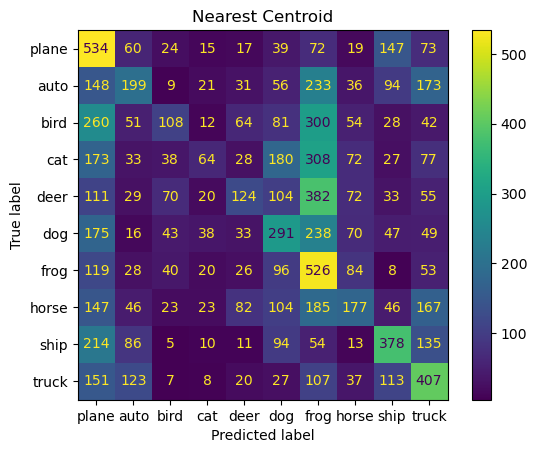

TypeError: Invalid shape (3072,) for image data

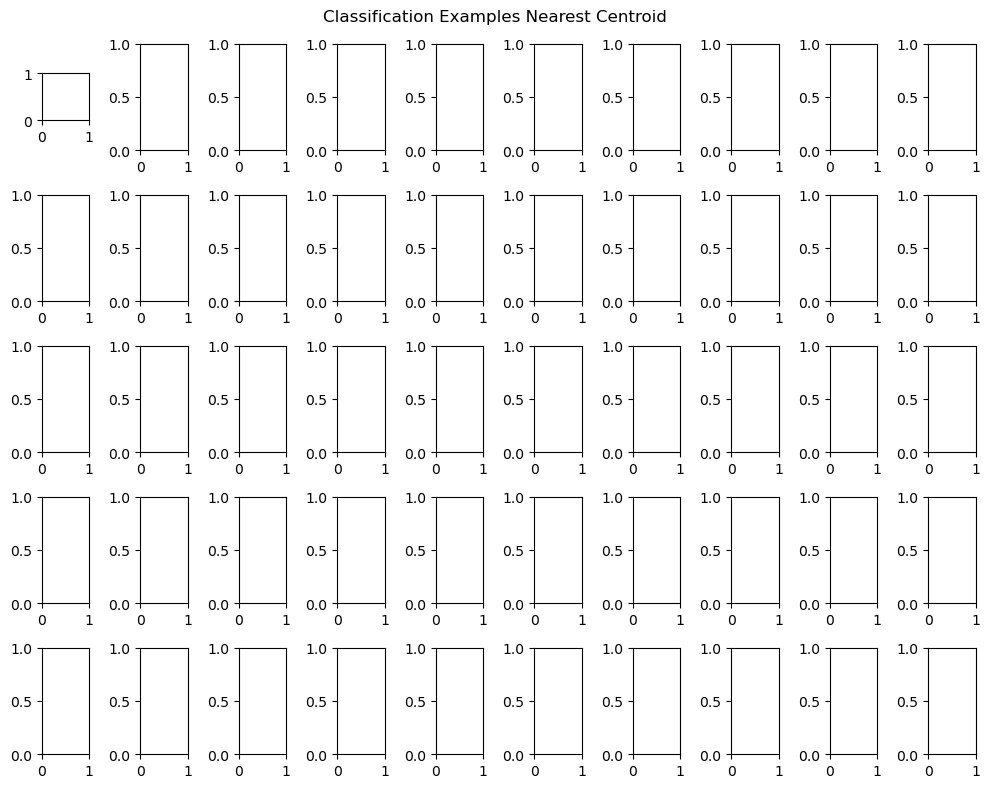

In [25]:
#Training nearest_centroid on train set
cn,cn_name = train_model(X_pca,y,'nearest_centroid')
#Evaluating nearest_centroid on test set
_,_,_ = evaluate_model(cn,X_test_pca,y_test,cn_name,label,X_test,whoim='rand')

1-NN

1-NN:
Training time elapsed: 53.45 ms.
Prediction time elapsed: 3741.78 ms.
Accuracy: 0.3743
              plane      auto      bird       cat      deer       dog      frog     horse      ship     truck   average
recall     0.497000  0.271000  0.387000  0.256000  0.462000  0.280000  0.407000  0.348000  0.606000  0.229000  0.374300
precision  0.434441  0.637647  0.258690  0.314496  0.264453  0.368906  0.331433  0.584874  0.429787  0.599476  0.422420
f1         0.463619  0.380351  0.310096  0.282249  0.336367  0.318363  0.365350  0.436364  0.502905  0.331404  0.372707


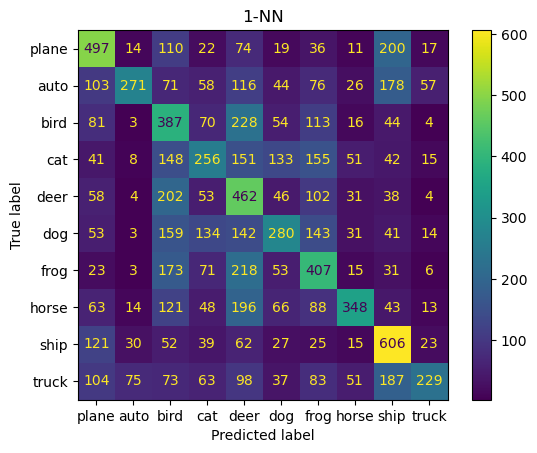

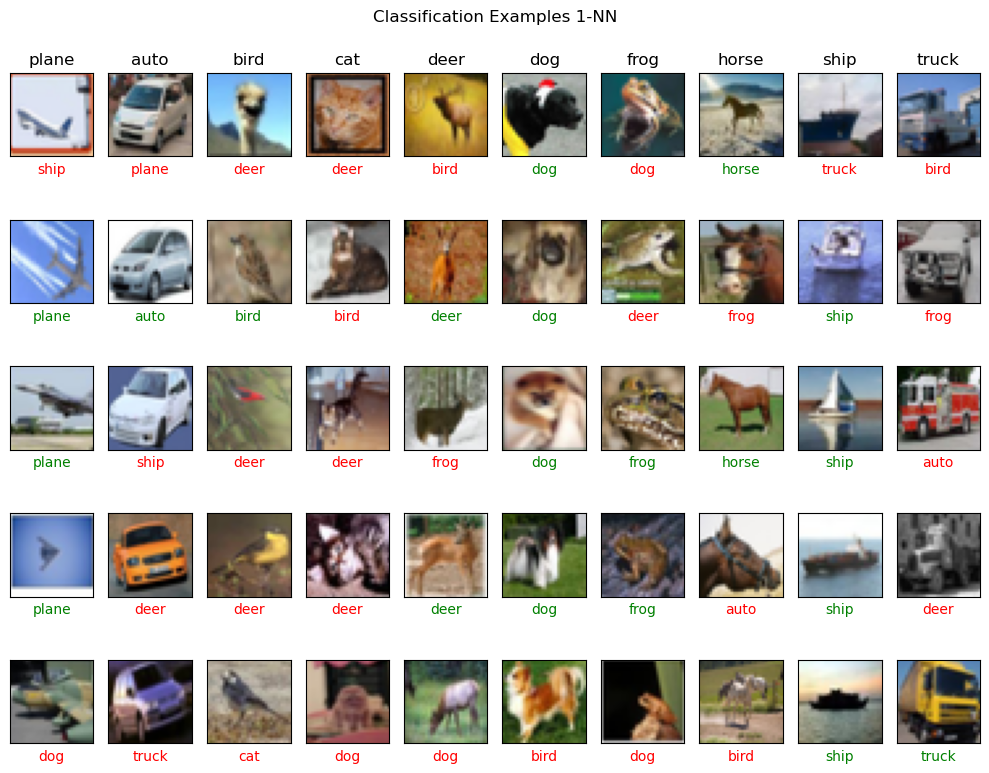

In [6]:
#Training 1-NN on train set
nn1,nn1_name = train_model(X_pca,y,'NN',kN=1)
#Evaluating 1-NN on test set
_,_,_ = evaluate_model(nn1,X_test_pca,y_test,nn1_name,label,X_test,whoim='rand')

3-NN

3-NN:
Training time elapsed: 59.32 ms.
Prediction time elapsed: 4962.10 ms.
Accuracy: 0.3516


plane      auto      bird       cat      deer       dog  \
recall     0.587000  0.298000  0.466000  0.239000  0.444000  0.199000   
precision  0.335237  0.585462  0.214154  0.284524  0.266667  0.439294   
f1         0.426754  0.394964  0.293451  0.259783  0.333208  0.273916   

               frog     horse      ship     truck   average  
recall     0.306000  0.223000  0.590000  0.164000  0.351600  
precision  0.378245  0.705696  0.466035  0.762791  0.443810  
f1         0.338308  0.338906  0.520741  0.269959  0.344999

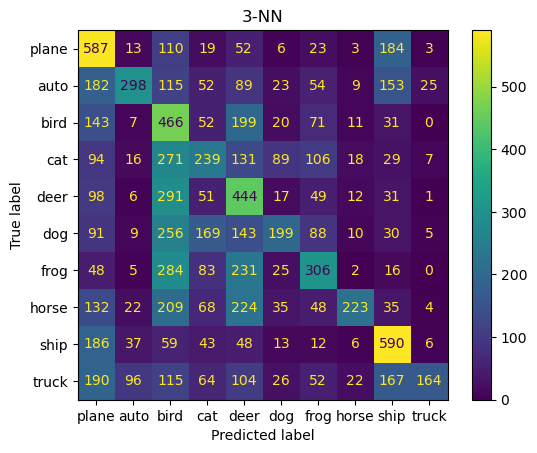

TypeError: Invalid shape (3072,) for image data

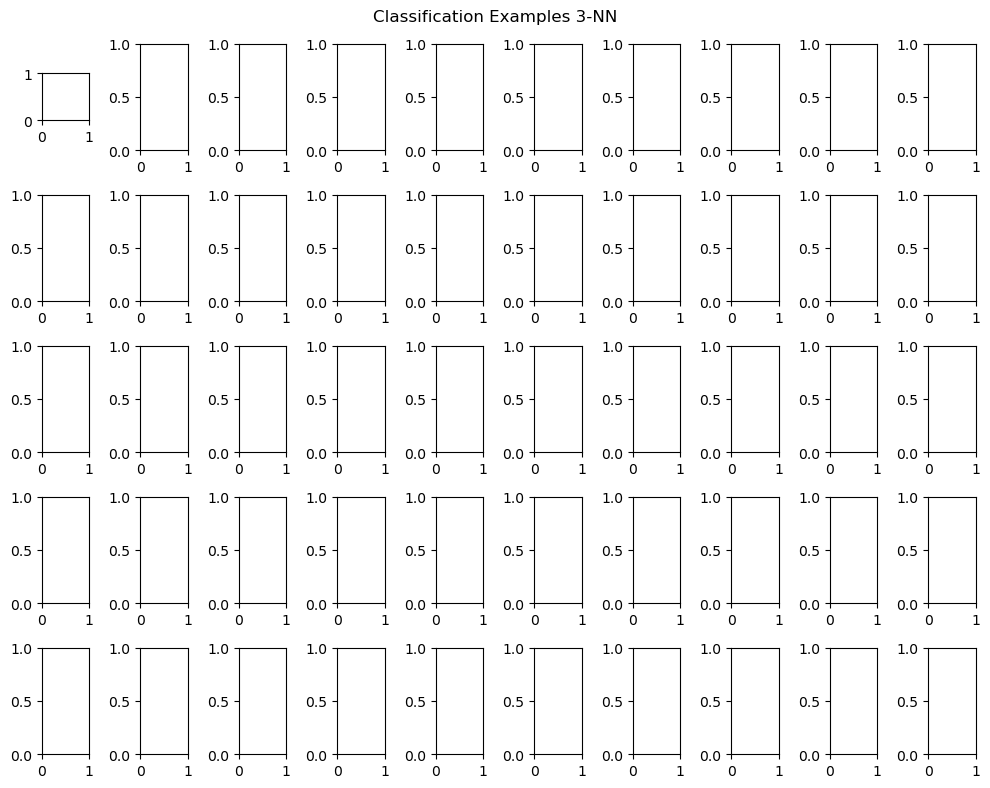

In [26]:
#Training 3-NN on train set
nn3,nn3_name = train_model(X_pca,y,'NN',kN=3)
#Evaluating 3-NN on test set
_,_,_ = evaluate_model(nn3,X_test_pca,y_test,nn3_name,label,X_test,whoim='rand')

LSVM

LSVM (C: 1.14e-04):
Training time elapsed: 36367.70 ms.
Prediction time elapsed: 4.42 ms.
Accuracy: 0.4040
              plane      auto      bird       cat      deer       dog      frog     horse      ship     truck   average
recall     0.493000  0.514000  0.178000  0.192000  0.246000  0.317000  0.574000  0.463000  0.575000  0.488000  0.404000
precision  0.425000  0.406968  0.320721  0.339223  0.414141  0.362700  0.393420  0.444765  0.443331  0.409740  0.396001
f1         0.456481  0.454264  0.228939  0.245211  0.308657  0.338314  0.466856  0.453699  0.500653  0.445459  0.389853


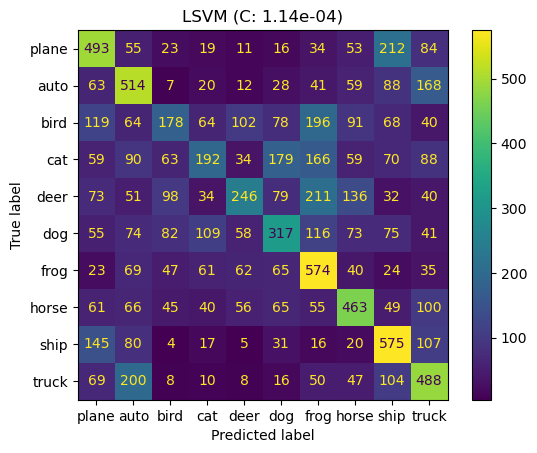

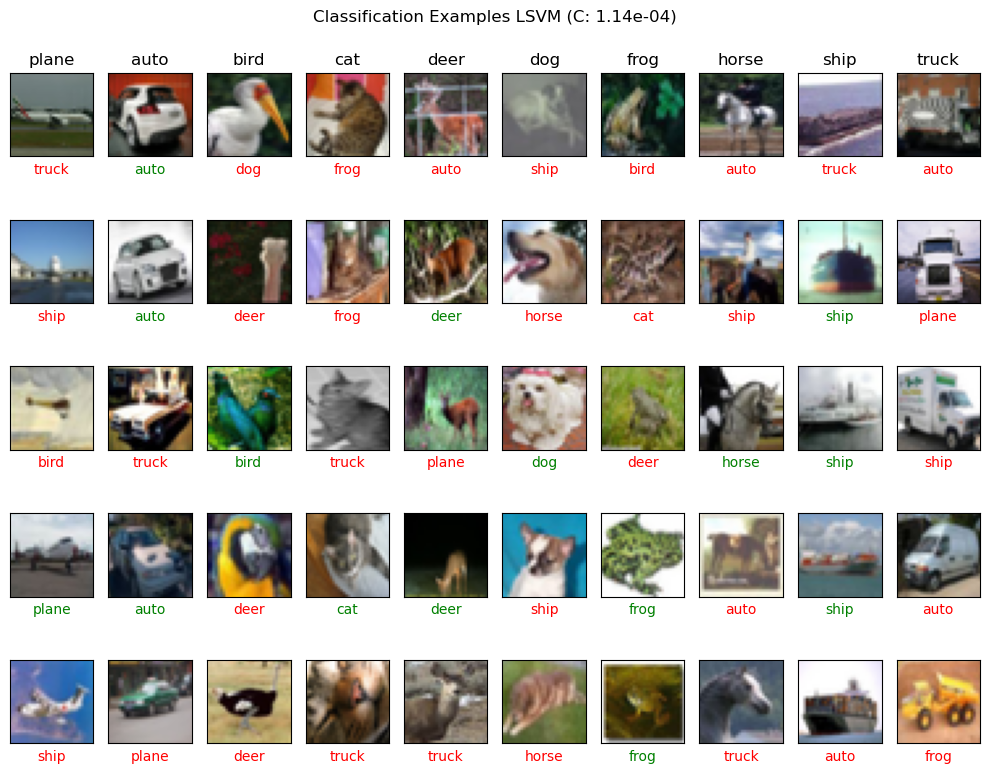

In [8]:
#Training tuned Linear SVM on train set
linSVM,lin_name=train_model(X_pca,y,'svm',{'kernel':'linear','C': 0.00011421052631578947})
#Evaluating Linear SVM on test set
_,_,_ = evaluate_model(linSVM,X_test_pca,y_test,lin_name,label,X_test,whoim='rand')

RBF

SVM (RBF, C: 3.36e+00, gamma: 6.91e-04):
Training time elapsed: 1290904.12 ms.
Prediction time elapsed: 136317.02 ms.
Accuracy: 0.5732
              plane      auto      bird       cat      deer       dog      frog     horse      ship     truck   average
recall     0.649000  0.681000  0.454000  0.408000  0.485000  0.489000  0.636000  0.604000  0.685000  0.641000  0.573200
precision  0.629486  0.655438  0.462793  0.379888  0.507853  0.519660  0.616877  0.677890  0.693320  0.599626  0.574283
f1         0.639094  0.667974  0.458354  0.393443  0.496164  0.503864  0.626292  0.638815  0.689135  0.619623  0.573276


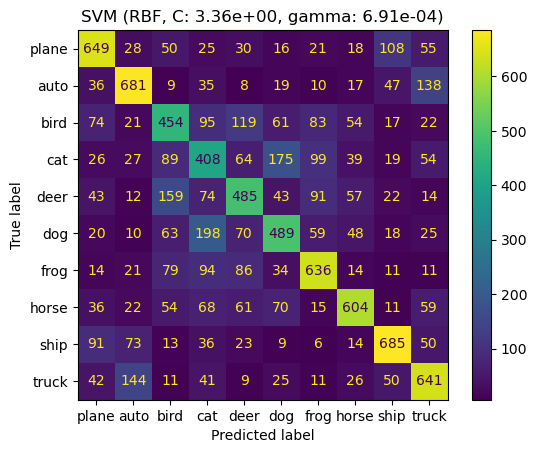

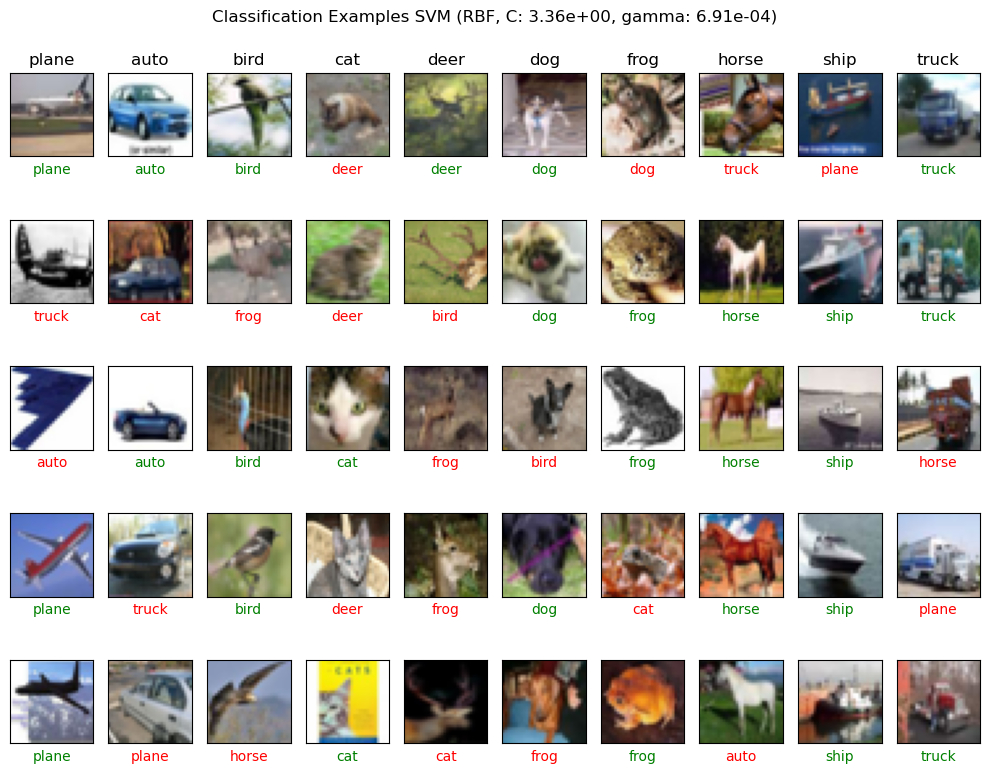

In [11]:
#Training tuned RBF SVM on train set
rbfSVM,rbf_name=train_model(X_pca,y,'svm',{'C': 3.363585661014858, 'gamma': 0.0006905339660024879, 'kernel': 'rbf'})
#Evaluating RBF SVM on test set
_,_,_ = evaluate_model(rbfSVM,X_test_pca,y_test,rbf_name,label,X_test,whoim='rand')

Polynomial

SVM (polynomial kernel of degree 3 (C: 3.12e-02, gamma: 1.95e-03):
Training time elapsed: 779441.11 ms.
Prediction time elapsed: 66945.83 ms.
Accuracy: 0.4845
              plane      auto      bird       cat      deer       dog      frog     horse      ship     truck   average
recall     0.554000  0.572000  0.432000  0.271000  0.549000  0.319000  0.561000  0.455000  0.623000  0.509000  0.484500
precision  0.547431  0.644870  0.298755  0.357049  0.328743  0.480422  0.523810  0.650930  0.624248  0.641058  0.509732
f1         0.550696  0.606253  0.353230  0.308130  0.411236  0.383413  0.541767  0.535609  0.623624  0.567447  0.488141


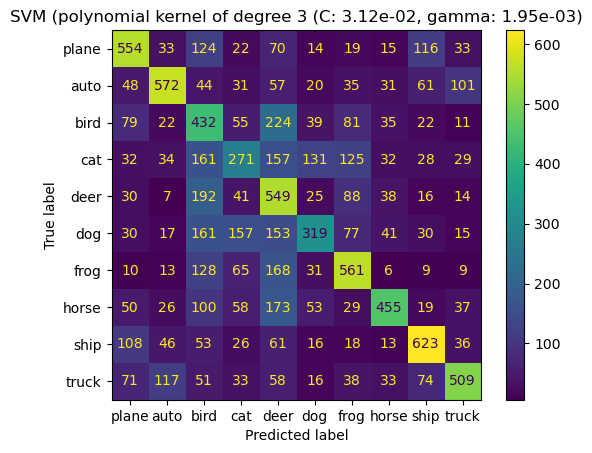

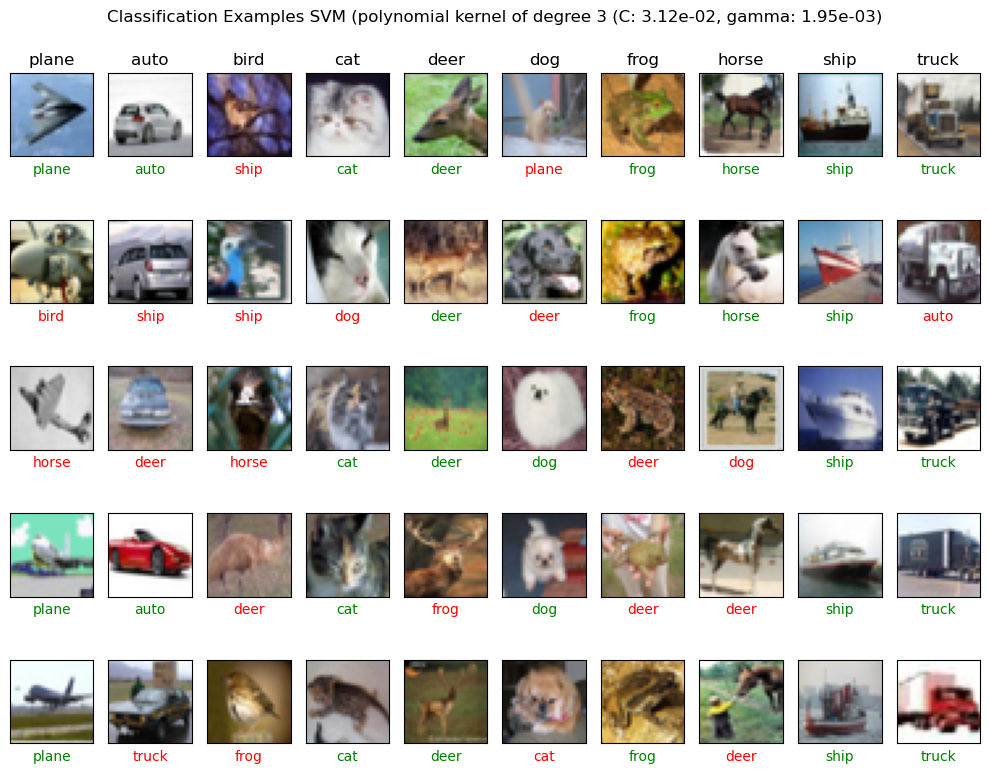

In [12]:
#Training tuned polynomial SVM on train set
polySVM,poly_name=train_model(X_pca,y,'svm',{'C': 0.03125, 'degree': 3, 'gamma': 0.001953125, 'kernel': 'poly'})
#Evaluating polynomial SVM on test set
_,_,_ = evaluate_model(polySVM,X_test_pca,y_test,poly_name,label,X_test,whoim='rand')

Sigmoid

SVM (sigmoid, C: 3.94e+01, gamma: 1.08e-05):
Training time elapsed: 598138.32 ms.
Prediction time elapsed: 76983.45 ms.
Accuracy: 0.4174
              plane      auto      bird       cat      deer       dog     frog     horse      ship     truck   average
recall     0.499000  0.480000  0.300000  0.311000  0.302000  0.327000  0.51200  0.427000  0.528000  0.488000  0.417400
precision  0.450361  0.477612  0.306435  0.309761  0.380353  0.344937  0.42917  0.494786  0.509161  0.456501  0.415908
f1         0.473435  0.478803  0.303183  0.310379  0.336678  0.335729  0.46694  0.458400  0.518409  0.471725  0.415368


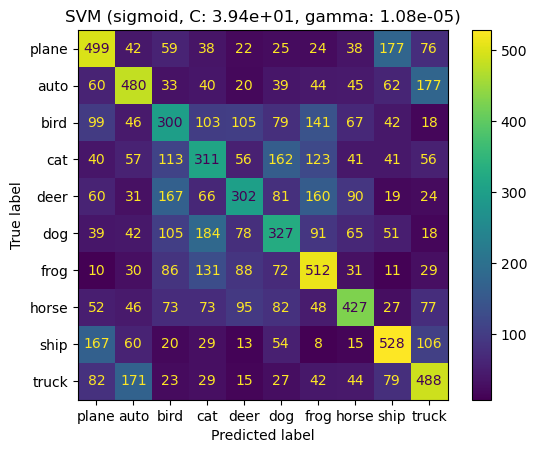

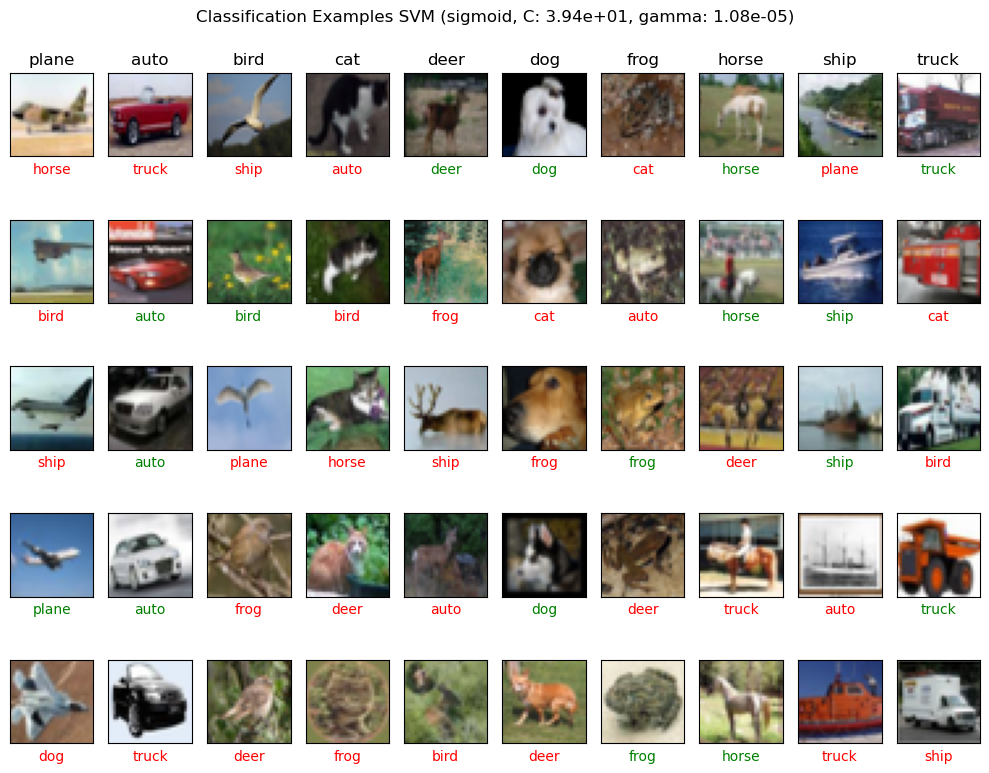

In [13]:
#Training tuned sigmoid SVM on train set
sigSVM,sig_name=train_model(X_pca,y,'svm',{'C': 39.39662122703734, 'gamma': 1.0789593218788873e-05, 'kernel': 'sigmoid'})
#Evaluating sigmoid SVM on test set
_,_,_ = evaluate_model(sigSVM,X_test_pca,y_test,sig_name,label,X_test,whoim='rand')

In [7]:
# cvrbf = gridsearch(X_pca[0:9999],y[0:9999],cv=3,kernel='rbf', C=2.0**np.arange(start=-5,stop=17,step=2),gamma= 2.0**np.arange(start=-15,stop=5,step=2))#[0:9999] so that its divisable by 3

Fitting 3 folds for each of 220 candidates, totalling 660 fits
{'C': 2.0, 'gamma': 0.00048828125, 'kernel': 'rbf'}


In [74]:
# cvrbf_fine = gridsearch(X_pca[0:9999],y[0:9999],cv=3,kernel='rbf', C=2.0**np.arange(start=1,stop=5.25,step=.25),gamma=2.0**np.arange(start=-12,stop=-9,step=.25))

Fitting 3 folds for each of 204 candidates, totalling 612 fits
{'C': 3.363585661014858, 'gamma': 0.0006905339660024879, 'kernel': 'rbf'}


In [75]:
# cv2_rbf = df(cvrbf_fine.cv_results_)
# cv2_rbf 

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        28.550031      0.106249        13.475707        0.520835     2.0   
1        29.255747      0.082670        19.765660        8.065992     2.0   
2        29.390131      1.123195        13.698696        0.221537     2.0   
3        29.917593      0.378129        13.671661        0.313940     2.0   
4        32.968432      0.174728        13.806893        0.309739     2.0   
..             ...           ...              ...             ...     ...   
199      43.560965      0.537615        15.959589        0.334355    32.0   
200      42.900395      0.183353        16.609252        0.273906    32.0   
201      44.076328      0.083669        23.358974        8.931638    32.0   
202      43.880986      2.393407        11.643136        1.796381    32.0   
203      35.136892      3.559220         7.542563        0.435708    32.0   

    param_gamma param_kernel  \
0      0.000244          rbf   
1       0.00029          rbf   
2      0.000345          rbf   
3      0.000411          rbf   
4      0.000488          rbf   
..          ...          ...   
199    0.000821          rbf   
200    0.000977          rbf   
201    0.001161          rbf   
202    0.001381          rbf   
203    0.001642          rbf   

                                                params  split0_test_score  \
0    {'C': 2.0, 'gamma': 0.000244140625, 'kernel': ...           0.469547   
1    {'C': 2.0, 'gamma': 0.0002903337683112112, 'ke...           0.469547   
2    {'C': 2.0, 'gamma': 0.00034526698300124393, 'k...           0.470447   
3    {'C': 2.0, 'gamma': 0.0004105939527606028, 'ke...           0.473747   
4    {'C': 2.0, 'gamma': 0.00048828125, 'kernel': '...           0.473747   
..                                                 ...                ...   
199  {'C': 32.0, 'gamma': 0.0008211879055212056, 'k...           0.468947   
200  {'C': 32.0, 'gamma': 0.0009765625, 'kernel': '...           0.469547   
201  {'C': 32.0, 'gamma': 0.0011613350732448448, 'k...           0.459946   
202  {'C': 32.0, 'gamma': 0.0013810679320049757, 'k...           0.444044   
203  {'C': 32.0, 'gamma': 0.0016423758110424111, 'k...           0.422442   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0             0.460846           0.470447         0.466947        0.004329   
1             0.460546           0.471947         0.467347        0.004908   
2             0.462946           0.473447         0.468947        0.004416   
3             0.467747           0.477048         0.472847        0.003850   
4             0.468347           0.475848         0.472647        0.003159   
..                 ...                ...              ...             ...   
199           0.457846           0.472547         0.466447        0.006257   
200           0.443444           0.460246         0.457746        0.010802   
201           0.429943           0.451845         0.447245        0.012673   
202           0.419442           0.431143         0.431543        0.010048   
203           0.400240           0.405041         0.409241        0.009538   

     rank_test_score  
0                 83  
1                 73  
2                 51  
3                  4  
4                  5  
..               ...  
199               96  
200              142  
201              162  
202              171  
203              195  

[204 rows x 14 columns]

In [47]:
# cvlinear = gridsearch(X_pca[0:9999],y[0:9999],cv=3,kernel='linear', C=2.0**np.arange(start=-5,stop=17,step=2))

Fitting 3 folds for each of 11 candidates, totalling 33 fits
{'C': 0.5}


In [48]:
# cv1_linear = df(cvlinear.cv_results_)
# cv1_linear

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0       16.794447      0.745922         0.025601        0.010869  0.03125   
1       16.756447      0.115917         0.018116        0.001342    0.125   
2       17.041291      0.878023         0.014860        0.006195      0.5   
3       16.891454      0.353587         0.011016        0.006649      2.0   
4       17.181248      0.245224         0.006975        0.001205      8.0   
5       17.250295      0.357709         0.007417        0.001873     32.0   
6       17.509125      0.424378         0.006218        0.000832    128.0   
7       17.478466      0.202982         0.007760        0.001686    512.0   
8       17.005006      0.197839         0.005756        0.000465   2048.0   
9       16.562510      0.226170         0.004785        0.000518   8192.0   
10      12.718841      4.841388         0.003878        0.000367  32768.0   

            params  split0_test_score  split1_test_score  split2_test_score  \
0   {'C': 0.03125}           0.373537           0.368737           0.371137   
1     {'C': 0.125}           0.374137           0.368437           0.371137   
2       {'C': 0.5}           0.374137           0.369037           0.371137   
3       {'C': 2.0}           0.374137           0.369037           0.370837   
4       {'C': 8.0}           0.374137           0.369037           0.370837   
5      {'C': 32.0}           0.374137           0.369037           0.370837   
6     {'C': 128.0}           0.374137           0.369037           0.370837   
7     {'C': 512.0}           0.374137           0.369037           0.370837   
8    {'C': 2048.0}           0.374137           0.369037           0.370837   
9    {'C': 8192.0}           0.374137           0.369037           0.370837   
10  {'C': 32768.0}           0.374137           0.369037           0.370837   

    mean_test_score  std_test_score  rank_test_score  
0          0.371137        0.001960               11  
1          0.371237        0.002328               10  
2          0.371437        0.002093                1  
3          0.371337        0.002112                2  
4          0.371337        0.002112                2  
5          0.371337        0.002112                2  
6          0.371337        0.002112                2  
7          0.371337        0.002112                2  
8          0.371337        0.002112                2  
9          0.371337        0.002112                2  
10         0.371337        0.002112                2

In [58]:
# cvlinear_wider = gridsearch(X_pca[0:9999],y[0:9999],cv=3,kernel='linear', C=10.0**np.arange(start=-7,stop=7,step=1))

Fitting 3 folds for each of 14 candidates, totalling 42 fits
{'C': 0.0001}


In [61]:
# cv2_linear = df(cvlinear_wider.cv_results_)
# cv2_linear

mean_fit_time  std_fit_time  mean_score_time  std_score_time    param_C  \
0        2.751428      0.013225         0.006713        0.002370        0.0   
1        4.285033      0.086833         0.010085        0.002856   0.000001   
2        7.988516      0.267006         0.006752        0.000929    0.00001   
3       13.918683      0.081527         0.005396        0.000453     0.0001   
4       16.414608      0.349143         0.005543        0.000376      0.001   
5       16.170293      0.500037         0.006090        0.000016       0.01   
6       16.809161      0.242309         0.005472        0.000458        0.1   
7       16.017509      0.676547         0.006598        0.000377        1.0   
8       16.276501      0.394705         0.006174        0.000065       10.0   
9       16.134549      0.160905         0.005729        0.000524      100.0   
10      16.753781      0.688312         0.006293        0.000647     1000.0   
11      16.488375      0.203170         0.006064        0.000805    10000.0   
12      14.897580      0.285720         0.004872        0.000684   100000.0   
13      11.324176      2.499996         0.003086        0.000326  1000000.0   

              params  split0_test_score  split1_test_score  split2_test_score  \
0       {'C': 1e-07}           0.272727           0.276628           0.270027   
1       {'C': 1e-06}           0.341434           0.352535           0.336934   
2       {'C': 1e-05}           0.383138           0.384038           0.378638   
3      {'C': 0.0001}           0.388839           0.388839           0.384638   
4       {'C': 0.001}           0.382238           0.375638           0.379838   
5        {'C': 0.01}           0.376238           0.369337           0.372337   
6         {'C': 0.1}           0.374137           0.368437           0.371137   
7         {'C': 1.0}           0.374137           0.369037           0.370837   
8        {'C': 10.0}           0.374137           0.369037           0.370837   
9       {'C': 100.0}           0.374137           0.369037           0.370837   
10     {'C': 1000.0}           0.374137           0.369037           0.370837   
11    {'C': 10000.0}           0.374137           0.369037           0.370837   
12   {'C': 100000.0}           0.374137           0.369037           0.370837   
13  {'C': 1000000.0}           0.374137           0.369037           0.370837   

    mean_test_score  std_test_score  rank_test_score  
0          0.273127        0.002710               14  
1          0.343634        0.006557               13  
2          0.381938        0.002362                2  
3          0.387439        0.001980                1  
4          0.379238        0.002728                3  
5          0.372637        0.002825                4  
6          0.371237        0.002328               12  
7          0.371337        0.002112                5  
8          0.371337        0.002112                5  
9          0.371337        0.002112                5  
10         0.371337        0.002112                5  
11         0.371337        0.002112                5  
12         0.371337        0.002112                5  
13         0.371337        0.002112                5

In [63]:
# cvlinear_fine = gridsearch(X_pca[0:9999],y[0:9999],cv=3,kernel='linear', C=np.linspace(start=0.00001,stop=0.001,num=20))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
{'C': 0.00011421052631578947}


In [64]:
# cv3_linear = df(cvlinear_fine.cv_results_)
# cv3_linear

mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_C  \
0        8.074015      0.090793         0.018784        0.002802   0.00001   
1       12.462460      0.325614         0.019094        0.000930  0.000062   
2       13.830079      0.302435         0.024786        0.015898  0.000114   
3       14.810599      0.236849         0.005754        0.000480  0.000166   
4       15.020385      0.545400         0.006458        0.000513  0.000218   
5       15.142532      0.045086         0.006142        0.000822  0.000271   
6       15.251560      0.315109         0.006640        0.000732  0.000323   
7       15.535649      0.289293         0.006291        0.001021  0.000375   
8       15.383045      0.520588         0.006059        0.000049  0.000427   
9       16.181228      0.481488         0.006589        0.002491  0.000479   
10      16.675256      0.229413         0.006243        0.002803  0.000531   
11      16.261588      0.624861         0.010434        0.006466  0.000583   
12      16.444262      0.836798         0.006448        0.000265  0.000635   
13      16.237314      0.662668         0.006042        0.000093  0.000687   
14      16.100723      0.245244         0.006546        0.001079  0.000739   
15      16.580565      0.525145         0.006357        0.000473  0.000792   
16      16.614630      0.367550         0.006227        0.000245  0.000844   
17      16.575263      0.211850         0.006441        0.000428  0.000896   
18      15.049675      1.309104         0.004969        0.000677  0.000948   
19      11.185824      1.495663         0.004205        0.001155     0.001   

                           params  split0_test_score  split1_test_score  \
0                    {'C': 1e-05}           0.383138           0.384038   
1    {'C': 6.210526315789474e-05}           0.385839           0.388539   
2   {'C': 0.00011421052631578947}           0.390939           0.388539   
3    {'C': 0.0001663157894736842}           0.390039           0.387939   
4   {'C': 0.00021842105263157895}           0.388539           0.384338   
5    {'C': 0.0002705263157894737}           0.387939           0.381338   
6   {'C': 0.00032263157894736843}           0.386139           0.380138   
7    {'C': 0.0003747368421052632}           0.385839           0.379838   
8    {'C': 0.0004268421052631579}           0.386439           0.379838   
9   {'C': 0.00047894736842105264}           0.387039           0.379838   
10   {'C': 0.0005310526315789474}           0.386139           0.378338   
11   {'C': 0.0005831578947368422}           0.385839           0.377438   
12   {'C': 0.0006352631578947368}           0.384938           0.377438   
13   {'C': 0.0006873684210526316}           0.383738           0.377138   
14   {'C': 0.0007394736842105264}           0.382538           0.376538   
15    {'C': 0.000791578947368421}           0.382238           0.376838   
16   {'C': 0.0008436842105263158}           0.382238           0.377138   
17   {'C': 0.0008957894736842106}           0.382538           0.376238   
18   {'C': 0.0009478947368421053}           0.382238           0.375938   
19                   {'C': 0.001}           0.382238           0.375638   

    split2_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.378638         0.381938        0.002362               11  
1            0.387939         0.387439        0.001158                2  
2            0.384038         0.387839        0.002860                1  
3            0.383138         0.387039        0.002888                3  
4            0.380138         0.384338        0.003430                4  
5            0.380438         0.383238        0.003344                5  
6            0.381338         0.382538        0.002593                7  
7            0.382238         0.382638        0.002466                6  
8            0.381038         0.382438        0.002871                9  
9            0.380738         0.382538        0.0

In [9]:
# cvpoly = gridsearch(X_pca[0:9999],y[0:9999],cv=3,kernel='poly', C=2.0**np.arange(start=-5,stop=17,step=4),gamma=2.0**np.arange(start=-15,stop=0,step=3),degree=np.array([3,8,11]))

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 1/3; 1/90] START C=0.03125, degree=3, gamma=3.0517578125e-05, kernel=poly...
[CV 1/3; 1/90] END C=0.03125, degree=3, gamma=3.0517578125e-05, kernel=poly;, score=0.103 total time=  11.1s
[CV 2/3; 1/90] START C=0.03125, degree=3, gamma=3.0517578125e-05, kernel=poly...
[CV 2/3; 1/90] END C=0.03125, degree=3, gamma=3.0517578125e-05, kernel=poly;, score=0.103 total time=  11.1s
[CV 3/3; 1/90] START C=0.03125, degree=3, gamma=3.0517578125e-05, kernel=poly...
[CV 3/3; 1/90] END C=0.03125, degree=3, gamma=3.0517578125e-05, kernel=poly;, score=0.103 total time=  12.4s
[CV 1/3; 2/90] START C=0.03125, degree=3, gamma=0.000244140625, kernel=poly.....
[CV 1/3; 2/90] END C=0.03125, degree=3, gamma=0.000244140625, kernel=poly;, score=0.150 total time=  11.3s
[CV 2/3; 2/90] START C=0.03125, degree=3, gamma=0.000244140625, kernel=poly.....
[CV 2/3; 2/90] END C=0.03125, degree=3, gamma=0.000244140625, kernel=poly;, score=0.151 total time=

In [10]:
# cv1_poly = df(cvpoly.cv_results_)
# cv1_poly 

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        8.168861      0.487898         3.445442        0.243792  0.03125   
1        7.949112      0.286155         3.216371        0.120577  0.03125   
2        7.069100      0.366713         3.253984        0.145484  0.03125   
3        9.102021      0.590997         2.981369        0.152193  0.03125   
4        8.875935      0.990727         2.967069        0.194855  0.03125   
..            ...           ...              ...             ...      ...   
85       7.857982      0.095480         3.237670        0.010054  32768.0   
86       9.771219      0.131236         3.035872        0.021113  32768.0   
87      10.741294      0.190889         2.985019        0.039191  32768.0   
88      10.794475      0.068895         2.970048        0.047732  32768.0   
89      10.726639      0.120352         2.968728        0.052433  32768.0   

   param_degree param_gamma param_kernel  \
0             3    0.000031         poly   
1             3    0.000244         poly   
2             3    0.001953         poly   
3             3    0.015625         poly   
4             3       0.125         poly   
..          ...         ...          ...   
85           11    0.000031         poly   
86           11    0.000244         poly   
87           11    0.001953         poly   
88           11    0.015625         poly   
89           11       0.125         poly   

                                               params  split0_test_score  \
0   {'C': 0.03125, 'degree': 3, 'gamma': 3.0517578...           0.103210   
1   {'C': 0.03125, 'degree': 3, 'gamma': 0.0002441...           0.149715   
2   {'C': 0.03125, 'degree': 3, 'gamma': 0.0019531...           0.385839   
3   {'C': 0.03125, 'degree': 3, 'gamma': 0.015625,...           0.365437   
4   {'C': 0.03125, 'degree': 3, 'gamma': 0.125, 'k...           0.366337   
..                                                ...                ...   
85  {'C': 32768.0, 'degree': 11, 'gamma': 3.051757...           0.103210   
86  {'C': 32768.0, 'degree': 11, 'gamma': 0.000244...           0.195020   
87  {'C': 32768.0, 'degree': 11, 'gamma': 0.001953...           0.213321   
88  {'C': 32768.0, 'degree': 11, 'gamma': 0.015625...           0.207321   
89  {'C': 32768.0, 'degree': 11, 'gamma': 0.125, '...           0.207321   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.103210           0.103210         0.103210        0.000000   
1            0.150615           0.149115         0.149815        0.000617   
2            0.392139           0.383438         0.387139        0.003669   
3            0.377438           0.373837         0.372237        0.005028   
4            0.377138           0.373537         0.372337        0.004490   
..                ...                ...              ...             ...   
85           0.102910           0.103210         0.103110        0.000141   
86           0.206721           0.195920         0.199220        0.005317   
87           0.210321           0.211821         0.211821        0.001225   
88           0.206121           0.211821         0.208421        0.002454   
89           0.206121           0.211821         0.208421        0.002454   

    rank_test_score  
0                79  
1                70  
2                 1  
3                24  
4                 9  
..              ...  
85               90  
86               66  
87               35  
88               53  
89               53  

[90 rows x 15 columns]

In [18]:
# cvpoly_fine = gridsearch(X_pca[0:9999],y[0:9999],cv=3,kernel='poly', C=2.0**np.arange(start=-5,stop=17,step=2),gamma=2.0**np.arange(start=-15,stop=5,step=2),degree=np.array([3]))

Fitting 3 folds for each of 110 candidates, totalling 330 fits
{'C': 0.03125, 'degree': 3, 'gamma': 0.001953125, 'kernel': 'poly'}


In [19]:
# cv1_poly = df(cvpoly_fine.cv_results_)
# cv1_poly 

mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        46.361708      0.197659        11.441742        0.058734  0.03125   
1        46.042562      0.100615        11.438749        0.031710  0.03125   
2        42.444184      1.326773        11.362287        0.461530  0.03125   
3        39.412621      0.589641        11.101651        0.229756  0.03125   
4        45.358059      1.444854        10.906506        0.228505  0.03125   
..             ...           ...              ...             ...      ...   
105      45.949479      1.647128         9.675131        0.391386  32768.0   
106      44.657266      2.212007         9.970356        0.342252  32768.0   
107      43.352794      0.518757         9.513232        0.233017  32768.0   
108      42.702866      1.784028         7.167170        0.222018  32768.0   
109      33.705917      5.064299         4.245312        0.974567  32768.0   

    param_degree param_gamma param_kernel  \
0              3    0.000031         poly   
1              3    0.000122         poly   
2              3    0.000488         poly   
3              3    0.001953         poly   
4              3    0.007812         poly   
..           ...         ...          ...   
105            3     0.03125         poly   
106            3       0.125         poly   
107            3         0.5         poly   
108            3         2.0         poly   
109            3         8.0         poly   

                                                params  split0_test_score  \
0    {'C': 0.03125, 'degree': 3, 'gamma': 3.0517578...           0.103210   
1    {'C': 0.03125, 'degree': 3, 'gamma': 0.0001220...           0.114611   
2    {'C': 0.03125, 'degree': 3, 'gamma': 0.0004882...           0.301830   
3    {'C': 0.03125, 'degree': 3, 'gamma': 0.0019531...           0.385839   
4    {'C': 0.03125, 'degree': 3, 'gamma': 0.0078125...           0.373537   
..                                                 ...                ...   
105  {'C': 32768.0, 'degree': 3, 'gamma': 0.03125, ...           0.366337   
106  {'C': 32768.0, 'degree': 3, 'gamma': 0.125, 'k...           0.366337   
107  {'C': 32768.0, 'degree': 3, 'gamma': 0.5, 'ker...           0.366337   
108  {'C': 32768.0, 'degree': 3, 'gamma': 2.0, 'ker...           0.366337   
109  {'C': 32768.0, 'degree': 3, 'gamma': 8.0, 'ker...           0.366337   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0             0.103210           0.103210         0.103210        0.000000   
1             0.112211           0.110711         0.112511        0.001606   
2             0.272127           0.271827         0.281928        0.014073   
3             0.392139           0.383438         0.387139        0.003669   
4             0.388239           0.375938         0.379238        0.006440   
..                 ...                ...              ...             ...   
105           0.377138           0.373537         0.372337        0.004490   
106           0.377138           0.373537         0.372337        0.004490   
107           0.377138           0.373537         0.372337        0.004490   
108           0.377138           0.373537         0.372337        0.004490   
109           0.377138           0.373537         0.372337        0.004490   

     rank_test_score  
0                108  
1                106  
2                 99  
3                  1  
4                 12  
..               ...  
105               26  
106               26  
107               26  
108               26  
109               26  

[110 rows x 15 columns]